### `import` Packages

In [127]:
import warnings
warnings.filterwarnings('ignore')

import re
import math
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter, defaultdict
from matplotlib import pyplot as plt
from matplotlib import style
style.use('seaborn-deep')

from scipy import sparse
from nltk.corpus import stopwords
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import normalize
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

### Data Reading

In [2]:
data_gv = pd.read_csv('training/training_variants')
data_text = pd.read_csv('training/training_text', sep='\|\|', engine='python', names=['ID', 'TEXT'], skiprows=1)

In [3]:
print(data_gv.shape)
print(data_text.shape)

(3321, 4)
(3321, 2)


In [4]:
data_gv.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [5]:
data_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [6]:
data_gv.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
dtype: int64

In [7]:
data_text.isnull().sum()

ID      0
TEXT    5
dtype: int64

### Processing Text

In [8]:
stop_words = set(stopwords.words('english'))

In [9]:
def is_stopword(word, sw=stop_words):
    if word not in sw:
        return True
    return False
    
def process_text(document):
    if not isinstance(document, str):
        return None
    
    # replace special char with space
    document = re.sub(pattern='[^a-zA-Z0-9\n]', repl=' ', string=document)
    # replace multiple spaces with single space
    document = re.sub(pattern='\s+', repl=' ', string=document)
    # convert the text into lower
    document = document.lower()
    # split the document string by space
    doc_words = document.split()
    # filter the words only if they are not in stopwords
    doc_filtered_words = list(filter(is_stopword, doc_words))
    # join the list as string
    proc_document = ' '.join(doc_filtered_words)
    
    return proc_document

In [10]:
proc_text = list(map(process_text, tqdm(data_text['TEXT'].to_list())))
data_text['TEXT'] = proc_text

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3321/3321 [00:44<00:00, 75.30it/s]


In [11]:
data_text.head()

,ID,TEXT
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas b lineag...


### Merge Datasets

In [12]:
results_df = pd.merge(left=data_gv, right=data_text, on='ID', how='left')

In [13]:
results_df.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


### Fetch `NaN` Indices

In [14]:
def fetch_nan_indices(dframe):
    nan_places = []
    
    for col in dframe.columns:
        indices = list(np.where(dframe[col].isnull())[0])
        nan_places.extend(indices)
    nan_places.sort()
    
    return nan_places

In [15]:
nan_indices = fetch_nan_indices(dframe=results_df)

In [16]:
print(nan_indices)

[1109, 1277, 1407, 1639, 2755]


In [17]:
results_df.iloc[nan_indices]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,None
1277,1277,ARID5B,Truncating Mutations,1,None
1407,1407,FGFR3,K508M,6,None
1639,1639,FLT1,Amplification,6,None
2755,2755,BRAF,G596C,7,None


### Replace `NaN` `TEXT` with `Gene` and `Variation`

In [18]:
results_df.loc[results_df['TEXT'].isnull(), 'TEXT'] = results_df['Gene'] + ' ' + results_df['Variation']

In [19]:
results_df.iloc[nan_indices]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F
1277,1277,ARID5B,Truncating Mutations,1,ARID5B Truncating Mutations
1407,1407,FGFR3,K508M,6,FGFR3 K508M
1639,1639,FLT1,Amplification,6,FLT1 Amplification
2755,2755,BRAF,G596C,7,BRAF G596C


### Features and Target

In [20]:
y = results_df['Class'].values

X = results_df.drop(columns=['Class'])
X['Gene'] = X['Gene'].str.replace('\s+', '_')
X['Variation'] = X['Variation'].str.replace('\s+', '_')

### Train Test Validation Split - (64:20:16)

In [21]:
train_df, test_df, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
train_df, cv_df, y_train, y_cv = train_test_split(train_df, y_train, stratify=y_train, test_size=0.2)

In [22]:
X_train = train_df.values
X_test = test_df.values
X_cv = cv_df.values

print(X_train.shape)
print(X_test.shape)
print(X_cv.shape)

(2124, 4)
(665, 4)
(532, 4)


In [23]:
def plot_class_distribution(class_data):
    class_freq = dict(
        sorted(Counter(class_data).items(), key=lambda x:x[0], reverse=False)
    )
    
    x = list(class_freq.keys())
    y = list(class_freq.values())
    y_sum = sum(y)
    
    # the plot shows that the data is imbalanced
    plt.figure()
    plt.bar(x, y)
    plt.grid()
    plt.xlabel('Class')
    plt.ylabel('Class Frequency')
    plt.title('Distribution of $y_i$')
    plt.show()
    
    for i in range(len(x)):
        print('Number of data points in class {} : {} \t| Percentage ratio - {}%'.format(
            x[i], y[i], round((y[i] / y_sum)*100, 3)
        ))
    
    return None

**`y_train` distribution**

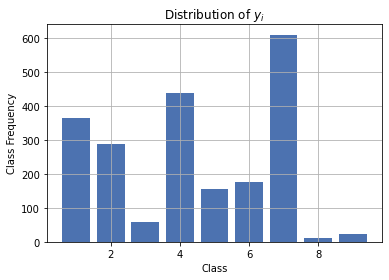

Number of data points in class 1 : 363 	| Percentage ratio - 17.09%
Number of data points in class 2 : 289 	| Percentage ratio - 13.606%
Number of data points in class 3 : 57 	| Percentage ratio - 2.684%
Number of data points in class 4 : 439 	| Percentage ratio - 20.669%
Number of data points in class 5 : 155 	| Percentage ratio - 7.298%
Number of data points in class 6 : 176 	| Percentage ratio - 8.286%
Number of data points in class 7 : 609 	| Percentage ratio - 28.672%
Number of data points in class 8 : 12 	| Percentage ratio - 0.565%
Number of data points in class 9 : 24 	| Percentage ratio - 1.13%


In [24]:
plot_class_distribution(class_data=y_train)

**`y_test` distribution**

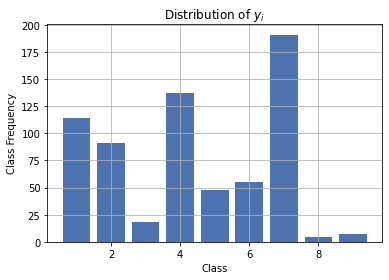

Number of data points in class 1 : 114 	| Percentage ratio - 17.143%
Number of data points in class 2 : 91 	| Percentage ratio - 13.684%
Number of data points in class 3 : 18 	| Percentage ratio - 2.707%
Number of data points in class 4 : 137 	| Percentage ratio - 20.602%
Number of data points in class 5 : 48 	| Percentage ratio - 7.218%
Number of data points in class 6 : 55 	| Percentage ratio - 8.271%
Number of data points in class 7 : 191 	| Percentage ratio - 28.722%
Number of data points in class 8 : 4 	| Percentage ratio - 0.602%
Number of data points in class 9 : 7 	| Percentage ratio - 1.053%


In [25]:
plot_class_distribution(class_data=y_test)

**`y_cv` distribution**

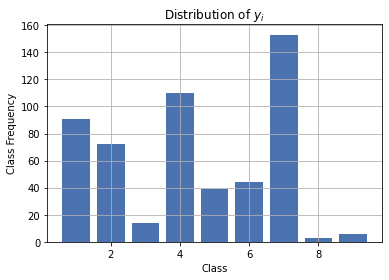

Number of data points in class 1 : 91 	| Percentage ratio - 17.105%
Number of data points in class 2 : 72 	| Percentage ratio - 13.534%
Number of data points in class 3 : 14 	| Percentage ratio - 2.632%
Number of data points in class 4 : 110 	| Percentage ratio - 20.677%
Number of data points in class 5 : 39 	| Percentage ratio - 7.331%
Number of data points in class 6 : 44 	| Percentage ratio - 8.271%
Number of data points in class 7 : 153 	| Percentage ratio - 28.759%
Number of data points in class 8 : 3 	| Percentage ratio - 0.564%
Number of data points in class 9 : 6 	| Percentage ratio - 1.128%


In [26]:
plot_class_distribution(class_data=y_cv)

### Confusion Matrix

In [27]:
def plot_heatmap(matrix, title, labels, cmap='YlGnBu'):
    plt.figure(figsize=(20, 7))
    sns.heatmap(matrix, annot=True, cmap=cmap, fmt='.3f', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title(title)
    plt.show()
    return None

def plot_confusion_matrix(y_actuals, y_preds):
    # confusion matrix
    cmat = confusion_matrix(y_true=y_actuals, y_pred=y_preds)
    # precision matrix
    pmat = cmat / cmat.sum(axis=0)
    # recall matrix
    rmat = cmat / cmat.sum(axis=1)
    # class labels
    labels = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    
    plot_heatmap(matrix=cmat, title='Confusion Matrix', labels=labels)
    plot_heatmap(matrix=pmat, title='Precision Matrix', labels=labels)
    plot_heatmap(matrix=rmat, title='Recall Matrix', labels=labels)
    
    return None

### Random Model

In [28]:
def build_rand_model(X, y):
    dummy_clf = DummyClassifier(strategy='uniform')
    dummy_clf.fit(X=X, y=y)
    prob_preds = dummy_clf.predict_proba(X)
    preds = dummy_clf.predict(X)
    print("Log loss : {}".format(log_loss(y_true=y, y_pred=prob_preds, eps=1e-15)))
    plot_confusion_matrix(y_actuals=y, y_preds=preds)
    return preds

Log loss : 2.1972245773362196


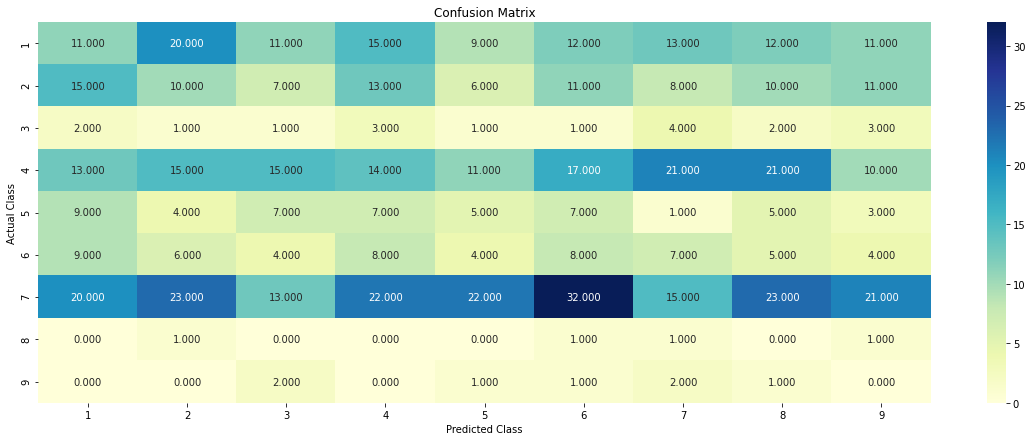

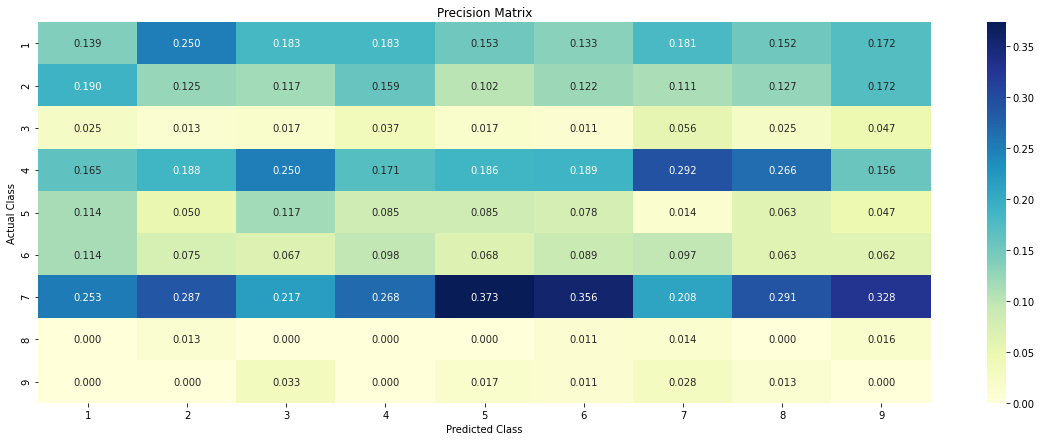

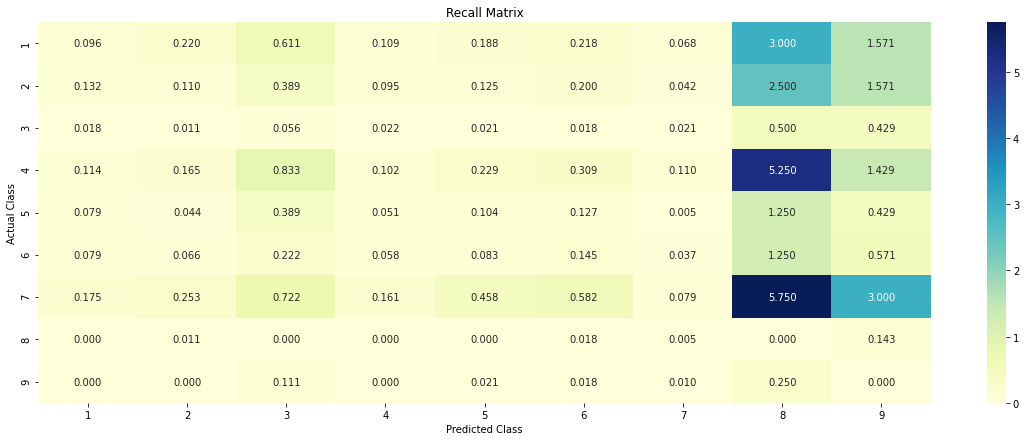

In [29]:
test_preds = build_rand_model(X=X_test, y=y_test)

In [30]:
# cv_preds = build_rand_model(X=X_cv, y=y_cv)

### Response Coding

In [31]:
train_df['Class'] = y_train
test_df['Class'] = y_test
cv_df['Class'] = y_cv

In [32]:
print(train_df.shape)
print(test_df.shape)
print(cv_df.shape)

(2124, 5)
(665, 5)
(532, 5)


In [33]:
def compute_feature_likelihood(dframe, feature, label, alpha_val, const=10):
    feature_label_df = dframe[[feature, label]]
    feature_vals = feature_label_df[feature].values
    
    feature_unique_df = feature_label_df[feature].value_counts().to_frame()
    feature_unique_vals = feature_unique_df.index.to_list()
    
    label_unique_df = feature_label_df[label].value_counts().to_frame()
    label_unique_vals = sorted(label_unique_df.index.to_list())
    
    feature_likelihood = {}
    for each_feature_val in feature_unique_vals:
        each_feature_df = feature_label_df[feature_label_df[feature] == each_feature_val]
        prob_d = len(each_feature_df)
        
        label_wise_prob = {}
        for each_label_val in label_unique_vals:
            each_feature_label_df = each_feature_df[each_feature_df[label] == each_label_val]
            prob_n = len(each_feature_label_df)
            # laplace smoothing
            label_wise_prob[each_label_val] = ( (prob_n + (alpha_val*const)) / (prob_d + (const*len(label_unique_vals))) )
        
        feature_likelihood[each_feature_val] = label_wise_prob
    
    return feature_vals, feature_unique_vals, label_unique_vals, feature_likelihood

In [34]:
# compute_feature_likelihood(dframe=train_df, feature='Gene', label='Class', alpha_val=1)

In [35]:
def get_response_code(train_df, test_df, cv_df, feature, label, alpha_val):
    feature_vals, feature_unique_vals, label_unique_vals, feature_likelihood = compute_feature_likelihood(
        dframe=train_df, feature=feature, label=label, alpha_val=alpha_val
    )
    
    # encoding train data by consiedering only train_df
    train_response_code_dict = {
        "{}-{}".format(feature, l) : [feature_likelihood[k][l] for k in train_df[feature]] for l in label_unique_vals
    }
    train_response_df = pd.DataFrame(train_response_code_dict)
    train_response_df[feature] = feature_vals
    
    # encoding test_df taking response table that is built on train_df
    test_response_code_mat = []
    for tval in test_df[feature]:
        try:
            tres_val = train_response_df[train_response_df[feature] == tval].values[0]
            tres_val = list(tres_val)
        except Exception as e:
            tres_val = [(1 / len(label_unique_vals)) for i in label_unique_vals]
            tres_val.append(tval)
        test_response_code_mat.append(tres_val)
    
    # encoding cv_df taking response table that is built on train_df
    cv_response_code_mat = []
    for cval in cv_df[feature]:
        try:
            cres_val = train_response_df[train_response_df[feature] == cval].values[0]
            cres_val = list(cres_val)
        except Exception as e:
            cres_val = [(1 / len(label_unique_vals)) for i in label_unique_vals]
            cres_val.append(cval)
        cv_response_code_mat.append(cres_val)
    
    test_response_code_mat = np.matrix(test_response_code_mat)
    cv_response_code_mat = np.matrix(cv_response_code_mat)
    
    test_response_df = pd.DataFrame(data=test_response_code_mat, columns=list(train_response_df.columns))
    cv_response_df = pd.DataFrame(data=cv_response_code_mat, columns=list(train_response_df.columns))
    
    train_response_df.drop(columns=[feature], axis=1, inplace=True)
    test_response_df.drop(columns=[feature], axis=1, inplace=True)
    cv_response_df.drop(columns=[feature], axis=1, inplace=True)
    
    return train_response_df.values, test_response_df.values, cv_response_df.values

In [36]:
# get_response_code(train_df=train_df, test_df=test_df, cv_df=cv_df, feature='Gene', label='Class', alpha_val=1)

### Univariate Analysis on `Gene` Feature

**Questions**

1. `Gene`, what type of feature is it?
2. How many categories are there? How are they distributed?
3. How to featurize the `Gene` feature?
4. How good is this `Gene` feaure in predicting the `Class` label?
5. Is `Gene` feature stable across the data sets (Train, Test, and Validation)?

**1. `Gene`, what type of feature is it?**

* `Gene` feature is categorical feature.

**2. How many categories are there? How are they distributed?**

In [37]:
unique_genes = train_df['Gene'].value_counts().to_frame()
print(unique_genes.shape)
unique_genes.head(10)

(236, 1)


,Gene
BRCA1,174
TP53,103
PTEN,90
BRCA2,81
EGFR,81
KIT,65
BRAF,56
ALK,43
ERBB2,41
PDGFRA,39


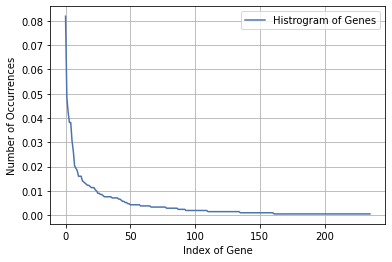

In [38]:
genes_sum = np.sum(unique_genes['Gene'])
genes_hist = unique_genes['Gene'].values / genes_sum

plt.plot(genes_hist, label="Histrogram of Genes")
plt.xlabel('Index of Gene')
plt.ylabel('Number of Occurrences')
plt.legend()
plt.grid()
plt.show()

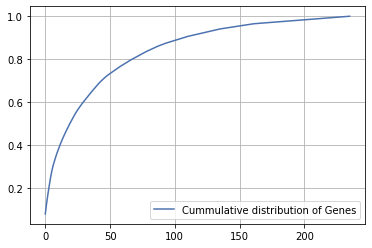

In [39]:
genes_cumm_freq = np.cumsum(genes_hist)

plt.plot(genes_cumm_freq, label='Cummulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

**3. How to featurize the `Gene` feature?**

* One-Hot-Encoding - better for logistice regression model
* Response Coding - better for RandomForests model

Response coding

In [40]:
train_gene_response_code, test_gene_response_code, cv_gene_response_code = get_response_code(
    train_df=train_df,
    test_df=test_df,
    cv_df=cv_df,
    feature='Gene',
    label='Class',
    alpha_val=1
)

In [41]:
print(train_gene_response_code.shape)
print(test_gene_response_code.shape)
print(cv_gene_response_code.shape)

(2124, 9)
(665, 9)
(532, 9)


One-Hot-Encoding

In [42]:
gene_vect = CountVectorizer()

train_gene_onehot_code = gene_vect.fit_transform(raw_documents=train_df['Gene'])
test_gene_onehot_code = gene_vect.transform(raw_documents=test_df['Gene'])
cv_gene_onehot_code = gene_vect.transform(raw_documents=cv_df['Gene'])

In [43]:
print(train_gene_onehot_code.shape)
print(test_gene_onehot_code.shape)
print(cv_gene_onehot_code.shape)

(2124, 235)
(665, 235)
(532, 235)


In [44]:
gene_vect.get_feature_names()[:5]

['abl1', 'acvr1', 'ago2', 'akt1', 'akt2']

**4. How good is this `Gene` feaure in predicting the `Class` label?**

* There are many ways to estimate how good a feature is, in predicting $y_i$.
* One of the good methods is to build a proper ML model using just this feature.
* In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict $y_i$.

In [45]:
def build_model(X_train, X_test, y_train, y_test, loss_type, alpha_params, show_confusion_matrix=False):
    log_error_array = []
    for i in alpha_params:
        clf = SGDClassifier(alpha=i, loss=loss_type, random_state=42)

        clf.fit(X_train, y_train)
        sig_clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid')
        sig_clf.fit(X_train, y_train)

        test_i_pred_y = sig_clf.predict_proba(X_test)
        lloss = log_loss(y_test, test_i_pred_y, labels=clf.classes_, eps=1e-15)
        log_error_array.append(lloss)

        print('For values of alpha = ', i, "The log loss is : ", lloss)

    plt.figure()
    plt.plot(alpha_params, log_error_array, c='g')

    for i, txt in enumerate(np.round(log_error_array, 3)):
        plt.annotate((alpha_params[i], np.round(txt, 3)), (alpha_params[i], log_error_array[i]))
    
    plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()

    best_alpha = np.argmin(log_error_array)
    clf = SGDClassifier(alpha=alpha_params[best_alpha], penalty='l2', loss=loss_type, random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)

    train_pred_y = sig_clf.predict_proba(X_train)
    print('For values of best alpha = ', alpha_params[best_alpha], "The train log loss is : ", log_loss(y_train, train_pred_y, labels=clf.classes_, eps=1e-15))

    test_pred_y = sig_clf.predict_proba(X_test)
    print('For values of best alpha = ', alpha_params[best_alpha], "The test log loss is : ", log_loss(y_test, test_pred_y, labels=clf.classes_, eps=1e-15))

    test_pred_y = np.argmax(test_pred_y, axis=1)
    print("Total number of data points : ", len(test_pred_y))
    
    if show_confusion_matrix:
        plot_confusion_matrix(y_test, test_pred_y)
    return None

**Checking for `cv_gene_onehot_code`**

For values of alpha =  1e-05 The log loss is :  1.195763080644337
For values of alpha =  0.0001 The log loss is :  1.173289533978049
For values of alpha =  0.001 The log loss is :  1.2233864802278853
For values of alpha =  0.01 The log loss is :  1.3444795710919226
For values of alpha =  0.1 The log loss is :  1.4314720558725245
For values of alpha =  1 The log loss is :  1.4717772872659947


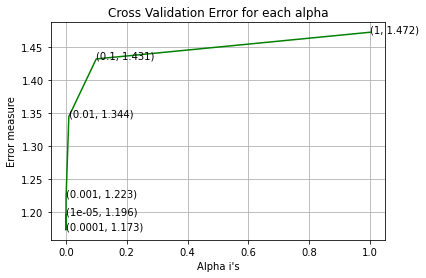

For values of best alpha =  0.0001 The train log loss is :  0.9943792321202782
For values of best alpha =  0.0001 The test log loss is :  1.173289533978049
Total number of data points :  532


In [46]:
alpha_params = [10 ** x for x in range(-5, 1)]

build_model(
    X_train=train_gene_onehot_code,
    X_test=cv_gene_onehot_code,
    y_train=y_train,
    y_test=y_cv,
    loss_type='log',
    alpha_params=alpha_params
)

**Checking for `test_gene_onehot_code`**

For values of alpha =  1e-05 The log loss is :  1.2178652019016285
For values of alpha =  0.0001 The log loss is :  1.1952282866786597
For values of alpha =  0.001 The log loss is :  1.2432994548815752
For values of alpha =  0.01 The log loss is :  1.3480130118483593
For values of alpha =  0.1 The log loss is :  1.4378772712334666
For values of alpha =  1 The log loss is :  1.4770852540130357


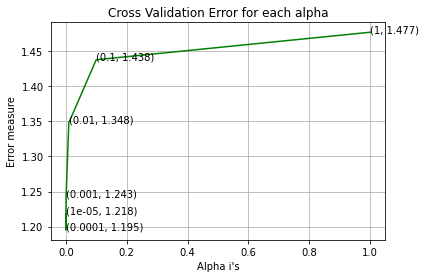

For values of best alpha =  0.0001 The train log loss is :  0.9943792321202782
For values of best alpha =  0.0001 The test log loss is :  1.1952282866786597
Total number of data points :  665


In [47]:
alpha_params = [10 ** x for x in range(-5, 1)]

build_model(
    X_train=train_gene_onehot_code,
    X_test=test_gene_onehot_code,
    y_train=y_train,
    y_test=y_test,
    loss_type='log',
    alpha_params=alpha_params
)

**5. Is `Gene` feature stable across the data sets (Train, Test, and Validation)?**

* Yes, it is. Otherwise, the `CV` and `Test` errors would be significantly more than `Train` error.

In [48]:
test_coverage = test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage = cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('1. In test data', test_coverage, 'out of ', test_df.shape[0], ":", (test_coverage / test_df.shape[0])*100)
print('2. In cross validation data', cv_coverage, 'out of ', cv_df.shape[0], ":", (cv_coverage / cv_df.shape[0])*100)

1. In test data 646 out of  665 : 97.14285714285714
2. In cross validation data 515 out of  532 : 96.80451127819549


### Univariate Analysis on `Variation` Feature

**Questions**

1. `Variation`, what type of feature is it?
2. How many categories are there? How are they distributed?
3. How to featurize the `Variation` feature?
4. How good is this `Variation` feaure in predicting the `Class` label?
5. Is `Variation` feature stable across the data sets (Train, Test, and Validation)?

**1. `Variation`, what type of feature is it?**

* `Variation` feature is categorical feature.

**2. How many categories are there? How are they distributed?**

In [49]:
unique_variation = train_df['Variation'].value_counts().to_frame()
print(unique_variation.shape)
unique_variation.head(10)

(1926, 1)


,Variation
Truncating_Mutations,55
Deletion,52
Amplification,44
Fusions,21
Overexpression,5
Q61L,3
E17K,3
G12C,2
ETV6-NTRK3_Fusion,2
F384L,2


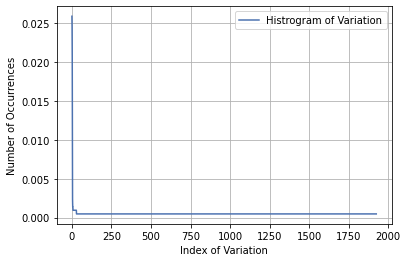

In [50]:
variation_sum = np.sum(unique_variation['Variation'])
variation_hist = unique_variation['Variation'].values / variation_sum

plt.plot(variation_hist, label="Histrogram of Variation")
plt.xlabel('Index of Variation')
plt.ylabel('Number of Occurrences')
plt.legend()
plt.grid()
plt.show()

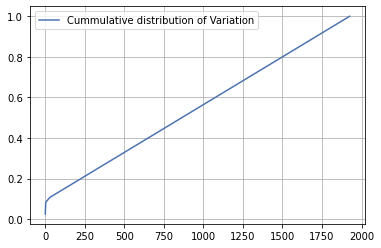

In [51]:
variation_cumm_freq = np.cumsum(variation_hist)

plt.plot(variation_cumm_freq, label='Cummulative distribution of Variation')
plt.grid()
plt.legend()
plt.show()

**3. How to featurize the `Gene` feature?**

* One-Hot-Encoding - better for logistice regression model
* Response Coding - better for RandomForests model

Response coding

In [52]:
train_variation_response_code, test_variation_response_code, cv_variation_response_code = get_response_code(
    train_df=train_df,
    test_df=test_df,
    cv_df=cv_df,
    feature='Variation',
    label='Class',
    alpha_val=1
)

In [53]:
print(train_variation_response_code.shape)
print(test_variation_response_code.shape)
print(cv_variation_response_code.shape)

(2124, 9)
(665, 9)
(532, 9)


One-Hot-Encoding

In [54]:
variation_vect = CountVectorizer()

train_variation_onehot_code = variation_vect.fit_transform(raw_documents=train_df['Variation'])
test_variation_onehot_code = variation_vect.transform(raw_documents=test_df['Variation'])
cv_variation_onehot_code = variation_vect.transform(raw_documents=cv_df['Variation'])

In [55]:
print(train_variation_onehot_code.shape)
print(test_variation_onehot_code.shape)
print(cv_variation_onehot_code.shape)

(2124, 1961)
(665, 1961)
(532, 1961)


In [56]:
variation_vect.get_feature_names()[:5]

['17', '1_2009trunc', '1_fusion', '2010_2471trunc', '256_286trunc']

**4. How good is this `Variation` feaure in predicting the `Class` label?**

* There are many ways to estimate how good a feature is, in predicting $y_i$.
* One of the good methods is to build a proper ML model using just this feature.
* In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict $y_i$.

**Checking for `cv_gene_onehot_code`**

For values of alpha =  1e-05 The log loss is :  1.6995218263029086
For values of alpha =  0.0001 The log loss is :  1.6893929096578455
For values of alpha =  0.001 The log loss is :  1.68885430522582
For values of alpha =  0.01 The log loss is :  1.694278480855749
For values of alpha =  0.1 The log loss is :  1.7152954444252164
For values of alpha =  1 The log loss is :  1.7179601980748846


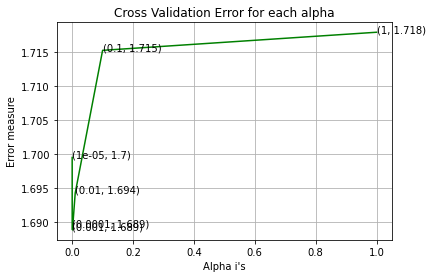

For values of best alpha =  0.001 The train log loss is :  1.0256945571481946
For values of best alpha =  0.001 The test log loss is :  1.68885430522582
Total number of data points :  532


In [57]:
alpha_params = [10 ** x for x in range(-5, 1)]

build_model(
    X_train=train_variation_onehot_code,
    X_test=cv_variation_onehot_code,
    y_train=y_train,
    y_test=y_cv,
    loss_type='log',
    alpha_params=alpha_params
)

**Checking for `test_gene_onehot_code`**

For values of alpha =  1e-05 The log loss is :  1.7242238881400869
For values of alpha =  0.0001 The log loss is :  1.7166182567925095
For values of alpha =  0.001 The log loss is :  1.7203900507781358
For values of alpha =  0.01 The log loss is :  1.7312221056905865
For values of alpha =  0.1 The log loss is :  1.7336494916077665
For values of alpha =  1 The log loss is :  1.7334125930398225


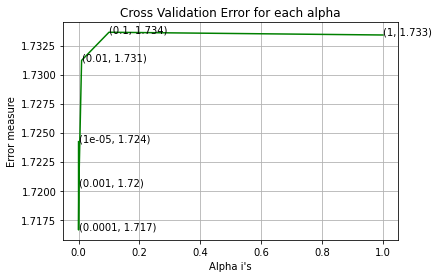

For values of best alpha =  0.0001 The train log loss is :  0.6603343902425334
For values of best alpha =  0.0001 The test log loss is :  1.7166182567925095
Total number of data points :  665


In [58]:
alpha_params = [10 ** x for x in range(-5, 1)]

build_model(
    X_train=train_variation_onehot_code,
    X_test=test_variation_onehot_code,
    y_train=y_train,
    y_test=y_test,
    loss_type='log',
    alpha_params=alpha_params
)

**5. Is `Variation` feature stable across the data sets (Train, Test, and Validation)?**

* Not sure, but the `CV` and `Test` errors are somewhat matching with `Train` error.

In [59]:
test_coverage = test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage = cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

print('1. In test data', test_coverage, 'out of ', test_df.shape[0], ":", (test_coverage / test_df.shape[0])*100)
print('2. In cross validation data', cv_coverage, 'out of ', cv_df.shape[0], ":", (cv_coverage / cv_df.shape[0])*100)

1. In test data 63 out of  665 : 9.473684210526317
2. In cross validation data 61 out of  532 : 11.466165413533833


### Univariate Analysis on `TEXT` Feature

**Questions**

1. `TEXT`, what type of feature is it?
2. How many categories are there? How are they distributed?
3. How to featurize the `TEXT` feature?
4. How good is this `TEXT` feaure in predicting the `TEXT` label?
5. Is `TEXT` feature stable across the data sets (Train, Test, and Validation)?

BoW

In [60]:
text_vect = CountVectorizer(min_df=3)
train_text_onehot_code = text_vect.fit_transform(raw_documents=train_df['TEXT'])
# feature names
train_text_features = text_vect.get_feature_names()
# feature count sum
train_text_features_sum = train_text_onehot_code.sum(axis=0).A1
# feature dictionary
text_feature_dictionary = dict(zip(train_text_features, train_text_features_sum))

print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 52955


**3. How to featurize the `TEXT` feature?**

In [61]:
class TextFeaturization:
    def __init__(self, unique_classes, alpha_val, const):
        self.unique_classes = unique_classes
        self.n_classes = len(self.unique_classes)
        self.alpha_val = alpha_val
        self.const = const
    
    def extract_dictionary_paddle(self, dframe, col_name):
        text_vals = dframe[col_name].to_list()
        text_dictionary = defaultdict(int)

        for val in text_vals:
            for word in val.split():
                text_dictionary[word] += 1

        return text_dictionary

    def extract_paddles_by_class(self, dframe, col_name, label):
        class_dictionary_paddle = []

        for each_class in self.unique_classes:
            class_frame = dframe[dframe[label] == each_class]
            class_dictionary_paddle.append(
                self.extract_dictionary_paddle(dframe=class_frame, col_name=col_name)
            )
        total_dictionary_paddle = self.extract_dictionary_paddle(
            dframe=dframe, col_name=col_name
        )

        return class_dictionary_paddle, total_dictionary_paddle

    def get_text_response_coding(self, dframe, col_name, train_class_dictionary, train_total_dictionary):
        text_vals = dframe[col_name].to_list()
        text_vals_split = list(map(str.split, text_vals))

        text_feature_response_code = np.zeros(shape=(dframe.shape[0], 9))

        for i in tqdm(range(self.n_classes)):
            row_index = 0
            for text_split in text_vals_split:
                sum_prob = 0
                for word in text_split:
                    # laplace smoothing
                    numerator = (train_class_dictionary[i].get(word, 0) + (self.alpha_val * self.const))
                    denominator = (train_total_dictionary.get(word, 0) + (self.n_classes * self.const))
                    sum_prob += math.log(numerator / denominator)
                text_feature_response_code[row_index][i] = math.exp(sum_prob / len(text_split))
                row_index += 1

        return text_feature_response_code

    def get_confuse_array(self, dframe, col_name, train_class_dictionary, train_total_dictionary, train_text_features):
        confuse_array = []

        for i in train_text_features:
            ratios = []
            max_val = -1
            for i in range(self.n_classes):
                # laplace smoothing
                numerator = (train_class_dictionary[j][i] + (self.alpha_val * self.const))
                denominator = (train_total_dictionary[i] + (self.n_classes * self.const))
                ratios.append(numerator / denominator)
            confuse_array.append(ratios)

        return np.matrix(confuse_array)

In [62]:
tfea = TextFeaturization(
    unique_classes = list(range(1, 10)),
    alpha_val=1,
    const=10
)

In [63]:
train_class_dictionary, train_total_dictionary = tfea.extract_paddles_by_class(
    dframe=train_df,
    col_name='TEXT',
    label='Class'
)

Response coding

In [64]:
print('Train Data')
train_text_response_code = tfea.get_text_response_coding(
    dframe=train_df,
    col_name='TEXT',
    train_class_dictionary=train_class_dictionary,
    train_total_dictionary=train_total_dictionary
)

print('Test Data')
test_text_response_code = tfea.get_text_response_coding(
    dframe=test_df,
    col_name='TEXT',
    train_class_dictionary=train_class_dictionary,
    train_total_dictionary=train_total_dictionary
)

print('CV Data')
cv_text_response_code = tfea.get_text_response_coding(
    dframe=cv_df,
    col_name='TEXT',
    train_class_dictionary=train_class_dictionary,
    train_total_dictionary=train_total_dictionary
)

Train Data


  0%|                                                                                                                                                                                                                 | 0/9 [00:00<?, ?it/s]

Test Data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:48<00:00,  5.34s/it]


CV Data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:37<00:00,  4.13s/it]


In [65]:
print(train_text_response_code.shape)
print(test_text_response_code.shape)
print(cv_text_response_code.shape)

(2124, 9)
(665, 9)
(532, 9)


One-Hot-Encoding

In [66]:
# train text one hot encoding
train_text_onehot_code = normalize(train_text_onehot_code, axis=0)

# test text one hot encoding
test_text_onehot_code = text_vect.transform(raw_documents=test_df['TEXT'])
test_text_onehot_code = normalize(test_text_onehot_code, axis=0)

# cv text one hot encoding
cv_text_onehot_code = text_vect.transform(raw_documents=cv_df['TEXT'])
cv_text_onehot_code = normalize(cv_text_onehot_code, axis=0)

In [67]:
print(train_text_onehot_code.shape)
print(test_text_onehot_code.shape)
print(cv_text_onehot_code.shape)

(2124, 52955)
(665, 52955)
(532, 52955)


In [68]:
sorted_text_feature_dictionary = dict(sorted(text_feature_dictionary.items(), key=lambda x: x[1], reverse=True))
sorted_text_occurrence = np.array(list(sorted_text_feature_dictionary.values()))

In [69]:
sorted_text_occurrence[:5]

array([150538, 118930,  79537,  67183,  67049], dtype=int64)

In [70]:
# Number of words for a given frequency
# print(Counter(sorted_text_occurrence))

**4. How good is this `TEXT` feaure in predicting the `TEXT` label?**

* There are many ways to estimate how good a feature is, in predicting $y_i$.
* One of the good methods is to build a proper ML model using just this feature.
* In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict $y_i$.

**Checking for `cv_text_onehot_code`**

For values of alpha =  1e-05 The log loss is :  1.3063478782518625
For values of alpha =  0.0001 The log loss is :  1.2288710178161406
For values of alpha =  0.001 The log loss is :  1.2068546955063255
For values of alpha =  0.01 The log loss is :  1.3334242134850087
For values of alpha =  0.1 The log loss is :  1.5449420070106785
For values of alpha =  1 The log loss is :  1.6841134356808143


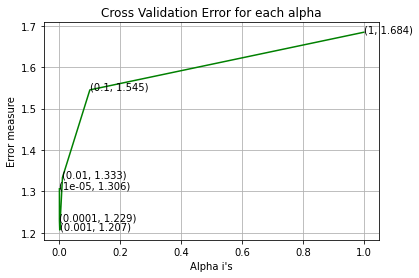

For values of best alpha =  0.001 The train log loss is :  0.6545900314976718
For values of best alpha =  0.001 The test log loss is :  1.2068546955063255
Total number of data points :  532


In [71]:
alpha_params = [10 ** x for x in range(-5, 1)]

build_model(
    X_train=train_text_onehot_code,
    X_test=cv_text_onehot_code,
    y_train=y_train,
    y_test=y_cv,
    loss_type='log',
    alpha_params=alpha_params
)

**Checking for `test_text_onehot_code`**

For values of alpha =  1e-05 The log loss is :  1.300545776007621
For values of alpha =  0.0001 The log loss is :  1.208516550124996
For values of alpha =  0.001 The log loss is :  1.19976994817388
For values of alpha =  0.01 The log loss is :  1.2871732217287337
For values of alpha =  0.1 The log loss is :  1.4602953172184414
For values of alpha =  1 The log loss is :  1.6470727026165628


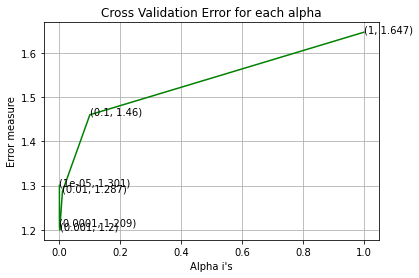

For values of best alpha =  0.001 The train log loss is :  0.6545900314976718
For values of best alpha =  0.001 The test log loss is :  1.19976994817388
Total number of data points :  665


In [72]:
alpha_params = [10 ** x for x in range(-5, 1)]

build_model(
    X_train=train_text_onehot_code,
    X_test=test_text_onehot_code,
    y_train=y_train,
    y_test=y_test,
    loss_type='log',
    alpha_params=alpha_params
)

**5. Is `TEXT` feature stable across the data sets (Train, Test, and Validation)?**

Yes, it seems.

In [73]:
def get_text_intersection(dframe, col_name, train_text_features):
    text_vect = CountVectorizer(min_df=3)
    text_onehot_code = text_vect.fit_transform(raw_documents=dframe[col_name])
    text_feature_names = text_vect.get_feature_names()
    text_feature_sum = text_onehot_code.sum(axis=0).A1
    text_feature_dictionary = dict(zip(text_feature_names, text_feature_sum))
    
    text_set_features = set(text_feature_names)
    train_set_features = set(train_text_features)
    
    len1 = len(text_set_features)
    len2 = len(train_set_features & text_set_features)
    
    return len1, len2

In [74]:
len1, len2 = get_text_intersection(dframe=test_df, col_name='TEXT', train_text_features=train_text_features)
print(np.round((len2 / len1)*100, 3), "% of word of test data appeared in train data")

len1, len2 = get_text_intersection(dframe=cv_df, col_name='TEXT', train_text_features=train_text_features)
print(np.round((len2 / len1)*100, 3), "% of word of validation appeared in train data")

97.102 % of word of test data appeared in train data
96.811 % of word of validation appeared in train data


### ML Models

In [75]:
def predict_and_plot_confusion_matrix(X_train, X_test, y_train, y_test, clf, show_plot=False):
    clf.fit(X_train, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    pred_y = sig_clf.predict(X_test)

    # for calculating log_loss we will provide the array of probabilities belongs to each class
    print("Log loss : ", log_loss(y_test, sig_clf.predict_proba(X_test)))
    
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points : ", np.count_nonzero((pred_y - y_test)) / y_test.shape[0])
    
    if show_plot:
        plot_confusion_matrix(y_actuals=y_test, y_preds=pred_y)
    
    return pred_y

In [76]:
def report_log_loss(X_train, X_test, y_train, y_test, clf):
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    sig_clf_probs = sig_clf.predict_proba(X_test)
    return log_loss(y_test, sig_clf_probs, eps=1e-15)

In [77]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not

def fetch_important_features(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word, yes_no))
        
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word, yes_no))
        
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word, yes_no))

    print("Out of the top ", no_features, " features ", word_present, "are present in query point")
    
    return None

### Horizontal Stacking of Data

**Stacking One-Hot-Encoded Data**

In [78]:
X_train_gvt_onehot_code = sparse.hstack(
    blocks=[train_gene_onehot_code, train_variation_onehot_code, train_text_onehot_code]
).tocsr()

X_test_gvt_onehot_code = sparse.hstack(
    blocks=[test_gene_onehot_code, test_variation_onehot_code, test_text_onehot_code]
).tocsr()

X_cv_gvt_onehot_code = sparse.hstack(
    blocks=[cv_gene_onehot_code, cv_variation_onehot_code, cv_text_onehot_code]
).tocsr()

In [79]:
print(X_train_gvt_onehot_code.shape)
print(X_test_gvt_onehot_code.shape)
print(X_cv_gvt_onehot_code.shape)

(2124, 55151)
(665, 55151)
(532, 55151)


**Stacking Response Coded Data**

In [80]:
X_train_gvt_response_code = np.hstack(
    tup=(train_gene_response_code, train_variation_response_code, train_text_response_code)
)

X_test_gvt_response_code = np.hstack(
    tup=(test_gene_response_code, test_variation_response_code, test_text_response_code)
)

X_cv_gvt_response_code = np.hstack(
    tup=(cv_gene_response_code, cv_variation_response_code, cv_text_response_code)
)

In [81]:
print(X_train_gvt_response_code.shape)
print(X_test_gvt_response_code.shape)
print(X_cv_gvt_response_code.shape)

(2124, 27)
(665, 27)
(532, 27)


### Model Development

In [91]:
def build_classifier_model(X_train, X_cv, X_test, y_train, y_cv, y_test, model_type, hparams, logify=False, show_plot=False):
    log_error_array = []
    for i in hparams:
        if (model_type == 'multinb'):
            clf = MultinomialNB(alpha=i)
        elif (model_type == 'knn'):
            clf = KNeighborsClassifier(n_neighbors=i)
        
        clf.fit(X_train, y_train)
        sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
        sig_clf.fit(X_train, y_train)
        sig_clf_probs = sig_clf.predict_proba(X_cv)
        lloss = log_loss(y_cv, sig_clf_probs, eps=1e-15)
        log_error_array.append(lloss)
        print("For alpha : {} → Log Loss : {}".format(i, lloss))
    
    hparams_logs = np.log10(hparams) if logify else hparams
    
    fig, ax = plt.subplots()
    ax.plot(hparams_logs, log_error_array, c='g')
    for (i, txt) in enumerate(np.round(log_error_array, 3)):
        ax.annotate((hparams[i], str(txt)), (hparams_logs[i], log_error_array[i]))
    plt.grid()
    plt.xticks(hparams_logs)
    plt.title("Cross Validation Plot of Parameters")
    plt.xlabel("Parameters")
    plt.ylabel('Errror Measure')
    plt.show()
    
    best_param = hparams[np.argmin(log_error_array)]
    if (model_type == 'multinb'):
        clf = MultinomialNB(alpha=best_param)
    elif (model_type == 'knn'):
        clf = KNeighborsClassifier(n_neighbors=best_param)
    
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(X_train, y_train)
    
    train_pred_prob_y = sig_clf.predict_proba(X_train)
    train_lloss = log_loss(y_train, train_pred_prob_y, eps=1e-15)
    print("For the best param : {}; the training log loss is : {}".format(best_param, train_lloss))
    
    cv_pred_prob_v = sig_clf.predict_proba(X_cv)
    cv_lloss = log_loss(y_cv, cv_pred_prob_v, eps=1e-15)
    print("For the best param : {}; the validation log loss is : {}".format(best_param, cv_lloss))
    
    test_pred_prob_y = sig_clf.predict_proba(X_test)
    test_lloss = log_loss(y_test, test_pred_prob_y, eps=1e-15)
    print("For the best param : {}; the training log loss is : {}".format(best_param, test_lloss))
    
    cv_pred_y = sig_clf.predict(X_cv)
    miss_cv = np.count_nonzero((cv_pred_y - y_cv)) / (y_cv.shape[0])
    print("Number of missclassified points in Validation data : {}".format(miss_cv))
    
    test_pred_y = sig_clf.predict(X_test)
    miss_test = np.count_nonzero((test_pred_y - y_test)) / (y_test.shape[0])
    print("Number of missclassified points in Test data : {}".format(miss_test))
    
    if show_plot:
        plot_confusion_matrix(y_cv, cv_pred_y)
    
    if (model_type == 'multinb'):
        return clf, sig_clf
    
    return clf, sig_clf, best_param

In [102]:
def build_linear_model(
    X_train,
    X_cv,
    X_test, y_train, y_cv, y_test, loss_type, hparams, logify=False, preserve_data_balancing=False, show_plot=False):
    
    pdb = 'balanced' if preserve_data_balancing else None
    log_error_array = []
    
    for i in hparams:
        clf = SGDClassifier(class_weight=pdb, alpha=i, penalty='l2', loss=loss_type, random_state=42)
        clf.fit(X_train, y_train)
        sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
        sig_clf.fit(X_train, y_train)
        sig_clf_probs = sig_clf.predict_proba(X_cv)
        lloss = log_loss(y_cv, sig_clf_probs, eps=1e-15)
        log_error_array.append(lloss)
        print("For alpha : {} → Log Loss : {}".format(i, lloss))
    
    hparams_logs = np.log10(hparams) if logify else hparams
    
    fig, ax = plt.subplots()
    ax.plot(hparams_logs, log_error_array, c='g')
    for (i, txt) in enumerate(np.round(log_error_array, 3)):
        ax.annotate((hparams[i], str(txt)), (hparams_logs[i], log_error_array[i]))
    plt.grid()
    plt.xticks(hparams_logs)
    plt.title("Cross Validation Plot of Parameters")
    plt.xlabel("Parameters")
    plt.ylabel('Errror Measure')
    plt.show()
    
    best_param = hparams[np.argmin(log_error_array)]
    clf = SGDClassifier(class_weight=pdb, alpha=best_param, penalty='l2', loss=loss_type, random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(X_train, y_train)
    
    train_pred_prob_y = sig_clf.predict_proba(X_train)
    train_lloss = log_loss(y_train, train_pred_prob_y, eps=1e-15)
    print("For the best param : {}; the training log loss is : {}".format(best_param, train_lloss))
    
    cv_pred_prob_v = sig_clf.predict_proba(X_cv)
    cv_lloss = log_loss(y_cv, cv_pred_prob_v, eps=1e-15)
    print("For the best param : {}; the validation log loss is : {}".format(best_param, cv_lloss))
    
    test_pred_prob_y = sig_clf.predict_proba(X_test)
    test_lloss = log_loss(y_test, test_pred_prob_y, eps=1e-15)
    print("For the best param : {}; the training log loss is : {}".format(best_param, test_lloss))
    
    cv_pred_y = sig_clf.predict(X_cv)
    miss_cv = np.count_nonzero((cv_pred_y - y_cv)) / (y_cv.shape[0])
    print("Number of missclassified points in Validation data : {}".format(miss_cv))
    
    test_pred_y = sig_clf.predict(X_test)
    miss_test = np.count_nonzero((test_pred_y - y_test)) / (y_test.shape[0])
    print("Number of missclassified points in Test data : {}".format(miss_test))
    
    if show_plot:
        plot_confusion_matrix(y_cv, cv_pred_y)
    
    return clf, sig_clf

In [125]:
def build_tree_classifiers(
    X_train, X_cv, X_test, 
    y_train, y_cv, y_test, 
    estimator_params, depth_parms, show_plot=False):
    
    log_error_array = []
    for i in estimator_params:
        for j in depth_parms:
            clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42)
            clf.fit(X_train, y_train)
            sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
            sig_clf.fit(X_train, y_train)
            sig_clf_probs = sig_clf.predict_proba(X_cv)
            lloss = log_loss(y_cv, sig_clf_probs, eps=1e-15)
            log_error_array.append(lloss)
            print("For estimator : {}; depth : {} → Log Loss : {}".format(i, j, lloss))
    
    best_parm = np.argmin(log_error_array)
    best_estimator = estimator_params[int(best_parm / 2)]
    best_depth = depth_parms[int(best_parm % 2)]
    
    clf = RandomForestClassifier(n_estimators=best_estimator, criterion='gini', max_depth=best_depth, random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(X_train, y_train)
    
    train_pred_prob_y = sig_clf.predict_proba(X_train)
    train_lloss = log_loss(y_train, train_pred_prob_y, eps=1e-15)
    print("For estimator : {}; depth : {} → training Log Loss : {}".format(best_estimator, best_depth, train_lloss))
    
    cv_pred_prob_v = sig_clf.predict_proba(X_cv)
    cv_lloss = log_loss(y_cv, cv_pred_prob_v, eps=1e-15)
    print("For estimator : {}; depth : {} → validation Log Loss : {}".format(best_estimator, best_depth, cv_lloss))
    
    test_pred_prob_y = sig_clf.predict_proba(X_test)
    test_lloss = log_loss(y_test, test_pred_prob_y, eps=1e-15)
    print("For estimator : {}; depth : {} → testing Log Loss : {}".format(best_estimator, best_depth, test_lloss))
    
    cv_pred_y = sig_clf.predict(X_cv)
    miss_cv = np.count_nonzero((cv_pred_y - y_cv)) / (y_cv.shape[0])
    print("Number of missclassified points in Validation data : {}".format(miss_cv))
    
    test_pred_y = sig_clf.predict(X_test)
    miss_test = np.count_nonzero((test_pred_y - y_test)) / (y_test.shape[0])
    print("Number of missclassified points in Test data : {}".format(miss_test))
    
    if show_plot:
        plot_confusion_matrix(y_cv, cv_pred_y)
    
    return clf, sig_clf

In [83]:
def check_model_nb_perf(dframe, X_test, y_test, query_point_index, n_feature_nums, clf, sig_clf, text_col, gene_col, var_col):
    point_data = X_test[query_point_index]
    point_target = y_test[query_point_index]
    
    predicted_class = sig_clf.predict(point_data)
    # print(predicted_class)
    
    print('Predicted Class : {}'.format(predicted_class[0]))
    print('Predicted Class Probabilities : {}'.format(np.round(sig_clf.predict_proba(point_data), 4)))
    print('Actual Class : {}'.format(point_target))
    
    indices = np.argsort(-1 * abs(clf.coef_))[predicted_class - 1][:, :n_feature_nums]
    print('-'*50)
    fetch_important_features(
        indices=indices[0],
        text=dframe[text_col].iloc[query_point_index],
        gene=dframe[gene_col].iloc[query_point_index],
        var=dframe[var_col].iloc[query_point_index],
        no_features=n_feature_nums
    )
    
    return None

In [94]:
def check_model_knn_perf(X_test, y_test, y_train, query_point_index, clf, sig_clf, best_param):
    point_data = X_test[query_point_index].reshape(1, -1)
    point_target = y_test[query_point_index]
    
    predicted_class = sig_clf.predict(point_data)
    # print(predicted_class)
    
    print('Predicted Class : {}'.format(predicted_class[0]))
    print('Actual Class : {}'.format(point_target))
    
    neighbors = clf.kneighbors(point_data, best_param)
    print("The ", best_param," nearest neighbours of the test points belongs to classes ", y_train[neighbors[1][0]])
    print("Fequency of nearest points : ", Counter(y_train[neighbors[1][0]]))
    
    return None

In [121]:
def check_model_tree_perf(dframe, X_test, y_test, query_point_index, n_feature_nums, clf, sig_clf, text_col, gene_col, var_col):
    point_data = X_test[query_point_index]
    point_target = y_test[query_point_index]
    
    predicted_class = sig_clf.predict(point_data)
    print('Predicted Class : {}'.format(predicted_class[0]))
    print('Predicted Class Probabilities : {}'.format(np.round(sig_clf.predict_proba(point_data), 4)))
    print('Actual Class : {}'.format(point_target))
    
    indices = np.argsort(-clf.feature_importances_)[:n_feature_nums]
    print("-"*50)
    fetch_important_features(
        indices=indices[0],
        text=dframe[text_col].iloc[query_point_index],
        gene=dframe[gene_col].iloc[query_point_index],
        var=dframe[var_col].iloc[query_point_index],
        no_features=n_feature_nums
    )
    
    return None

**Multinomial Naive Bayes**

For alpha : 1e-05 → Log Loss : 1.308095770060653
For alpha : 0.0001 → Log Loss : 1.304630333668421
For alpha : 0.001 → Log Loss : 1.3073296264215977
For alpha : 0.1 → Log Loss : 1.2725914066528898
For alpha : 1 → Log Loss : 1.3123137429395992
For alpha : 10 → Log Loss : 1.4493716286445701
For alpha : 100 → Log Loss : 1.4504928113451834
For alpha : 1000 → Log Loss : 1.373810883594421


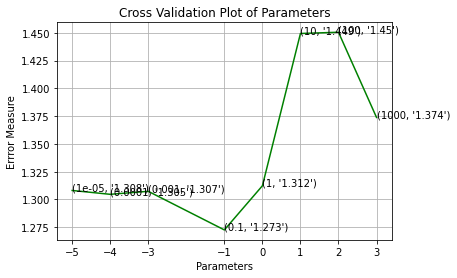

For the best param : 0.1; the training log loss is : 0.8654453524730635
For the best param : 0.1; the validation log loss is : 1.2725914066528898
For the best param : 0.1; the training log loss is : 1.2561553652603827
Number of missclassified points in Validation data : 0.39285714285714285
Number of missclassified points in Test data : 0.40150375939849625


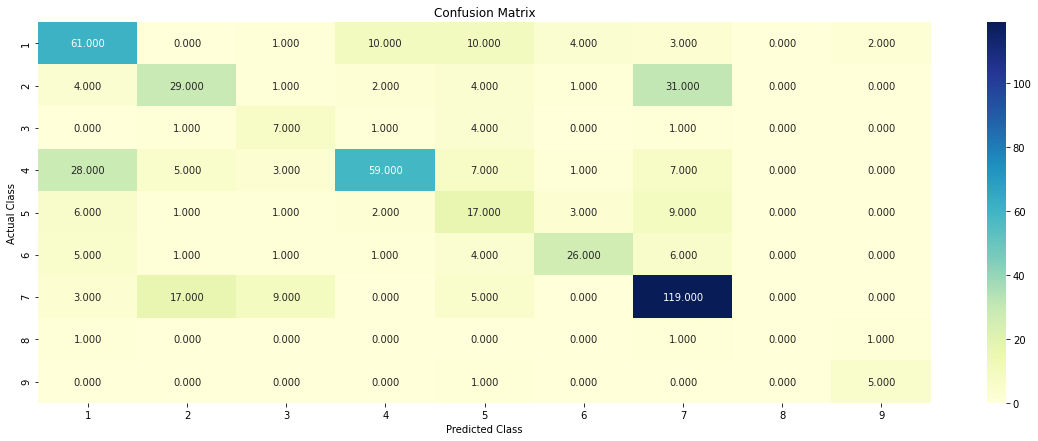

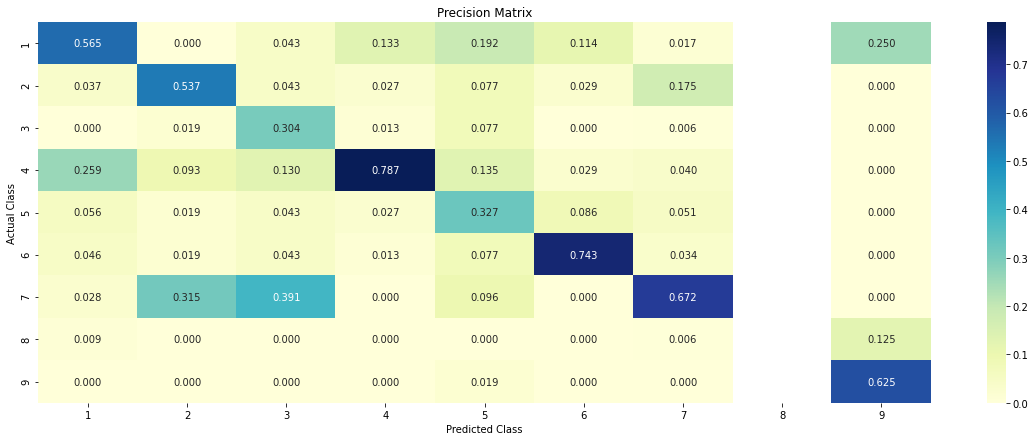

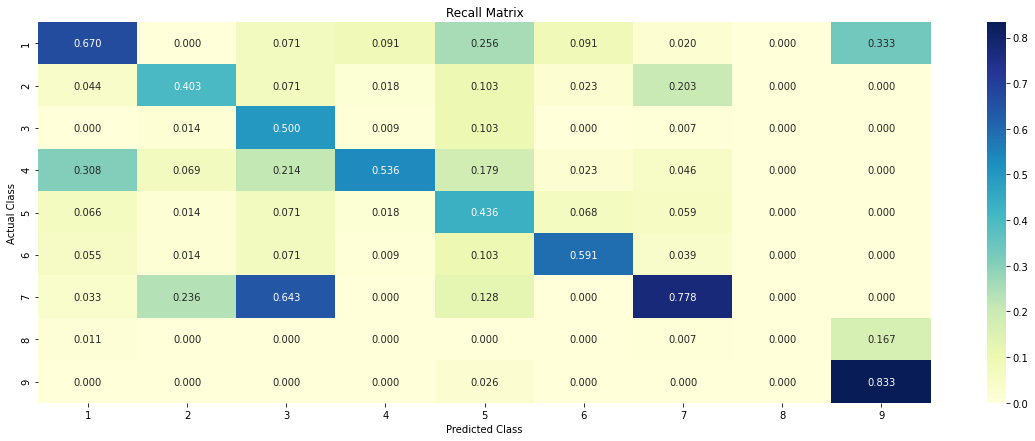

In [84]:
alpha_params = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]

multinb_clf, multinb_sig_clf = build_classifier_model(
    X_train=X_train_gvt_onehot_code,
    X_cv=X_cv_gvt_onehot_code,
    X_test=X_test_gvt_onehot_code,
    y_train=y_train,
    y_cv=y_cv,
    y_test=y_test,
    model_type='multinb',
    hparams=alpha_params,
    logify=True,
    show_plot=True
)

Feature Importance

In [85]:
check_model_nb_perf(
    dframe=test_df,
    X_test=X_test_gvt_onehot_code,
    y_test=y_test,
    query_point_index=1,
    n_feature_nums=100,
    clf=multinb_clf,
    sig_clf=multinb_sig_clf,
    text_col='TEXT',
    gene_col='Gene',
    var_col='Variation'
)

Predicted Class : 7
Predicted Class Probabilities : [[0.1118 0.0889 0.0135 0.1013 0.035  0.0374 0.602  0.0057 0.0044]]
Actual Class : 2
--------------------------------------------------
Out of the top  100  features  0 are present in query point


In [86]:
check_model_nb_perf(
    dframe=test_df,
    X_test=X_test_gvt_onehot_code,
    y_test=y_test,
    query_point_index=23,
    n_feature_nums=100,
    clf=multinb_clf,
    sig_clf=multinb_sig_clf,
    text_col='TEXT',
    gene_col='Gene',
    var_col='Variation'
)

Predicted Class : 7
Predicted Class Probabilities : [[0.0832 0.0718 0.0125 0.0956 0.033  0.0352 0.6592 0.0053 0.0042]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0 are present in query point


In [88]:
# for i in range(10):
#     print('Current Index : {}'.format(i))
#     print('='*60)
#     check_model_nb_perf(
#         dframe=test_df,
#         X_test=X_test_gvt_onehot_code,
#         y_test=y_test,
#         query_point_index=i,
#         n_feature_nums=100,
#         clf=multinb_clf,
#         sig_clf=multinb_sig_clf,
#         text_col='TEXT',
#         gene_col='Gene',
#         var_col='Variation'
#     )

**KNN Classifier**

For alpha : 5 → Log Loss : 1.1451231343128312
For alpha : 11 → Log Loss : 1.1206354683544846
For alpha : 15 → Log Loss : 1.0999447080719165
For alpha : 21 → Log Loss : 1.1079084514651827
For alpha : 31 → Log Loss : 1.1214112788494333
For alpha : 41 → Log Loss : 1.1319135947507617
For alpha : 51 → Log Loss : 1.136446532455016
For alpha : 99 → Log Loss : 1.140373928563713


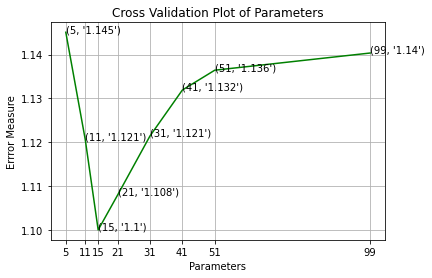

For the best param : 15; the training log loss is : 0.6633448509108686
For the best param : 15; the validation log loss is : 1.0999447080719165
For the best param : 15; the training log loss is : 1.0786238333048341
Number of missclassified points in Validation data : 0.3890977443609023
Number of missclassified points in Test data : 0.3969924812030075


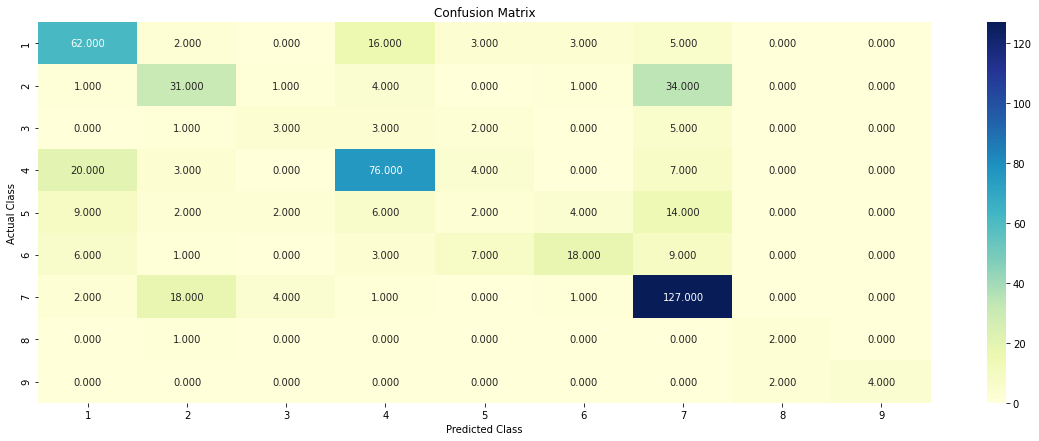

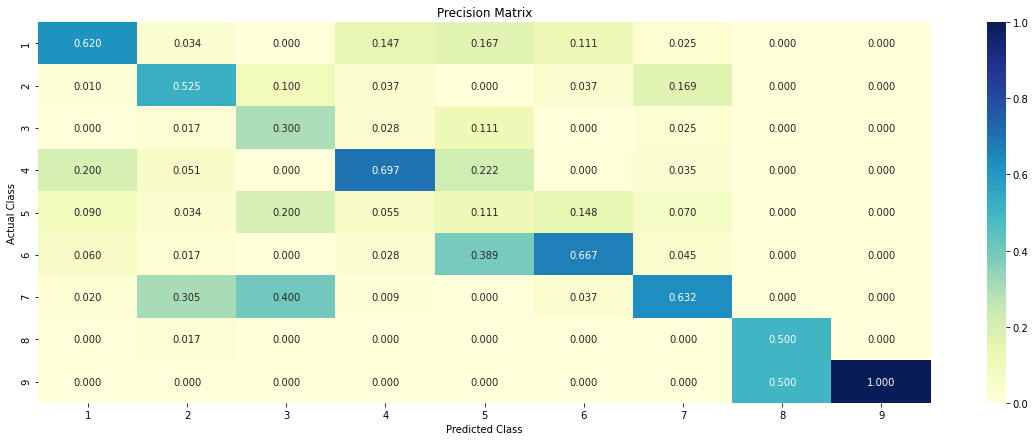

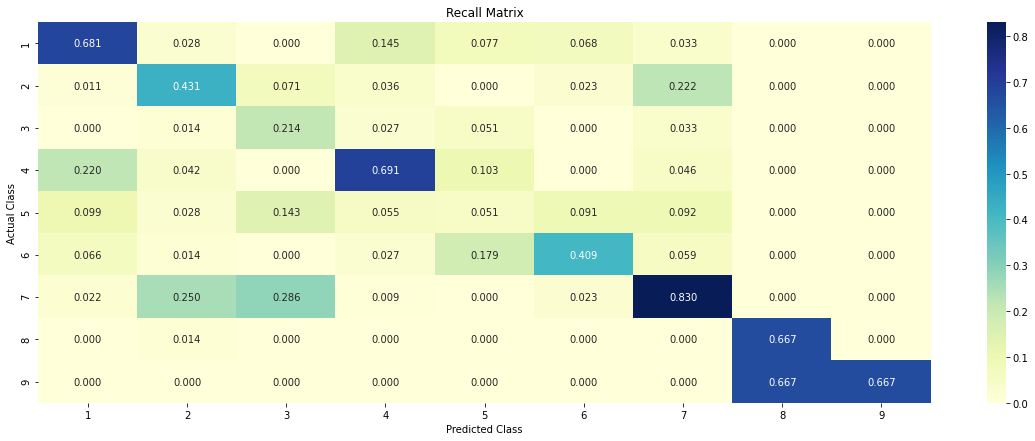

In [92]:
neighbor_params = [5, 11, 15, 21, 31, 41, 51, 99]

knn_clf, knn_sig_clf, knn_best_param = build_classifier_model(
    X_train=X_train_gvt_response_code,
    X_cv=X_cv_gvt_response_code,
    X_test=X_test_gvt_response_code,
    y_train=y_train,
    y_cv=y_cv,
    y_test=y_test,
    model_type='knn',
    hparams=neighbor_params,
    logify=False,
    show_plot=True
)

Model Performance

In [95]:
check_model_knn_perf(
    X_test=X_test_gvt_response_code,
    y_test=y_test,
    y_train=y_train,
    query_point_index=1,
    clf=knn_clf,
    sig_clf=knn_sig_clf,
    best_param=knn_best_param
)

Predicted Class : 2
Actual Class : 2
The  15  nearest neighbours of the test points belongs to classes  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Fequency of nearest points :  Counter({2: 15})


In [97]:
check_model_knn_perf(
    X_test=X_test_gvt_response_code,
    y_test=y_test,
    y_train=y_train,
    query_point_index=10,
    clf=knn_clf,
    sig_clf=knn_sig_clf,
    best_param=knn_best_param
)

Predicted Class : 7
Actual Class : 2
The  15  nearest neighbours of the test points belongs to classes  [7 7 7 2 7 7 7 7 7 7 7 7 7 7 7]
Fequency of nearest points :  Counter({7: 14, 2: 1})


**Logistic Regression** (with class balancing)

For alpha : 1e-06 → Log Loss : 1.3057321605739587
For alpha : 1e-05 → Log Loss : 1.2628004019015941
For alpha : 0.0001 → Log Loss : 1.168251102745528
For alpha : 0.001 → Log Loss : 1.1533109614070551
For alpha : 0.01 → Log Loss : 1.2076982901571605
For alpha : 0.1 → Log Loss : 1.5328684630118188
For alpha : 1 → Log Loss : 1.7269801451559743
For alpha : 10 → Log Loss : 1.745232031588359
For alpha : 100 → Log Loss : 1.747077797436609


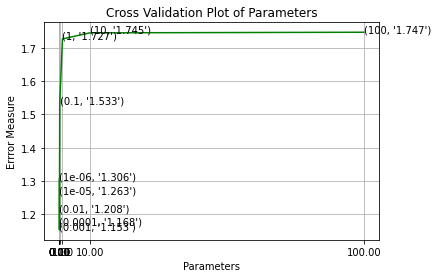

For the best param : 0.001; the training log loss is : 0.5131492420821834
For the best param : 0.001; the validation log loss is : 1.1533109614070551
For the best param : 0.001; the training log loss is : 1.1277935978102043
Number of missclassified points in Validation data : 0.35714285714285715
Number of missclassified points in Test data : 0.35789473684210527


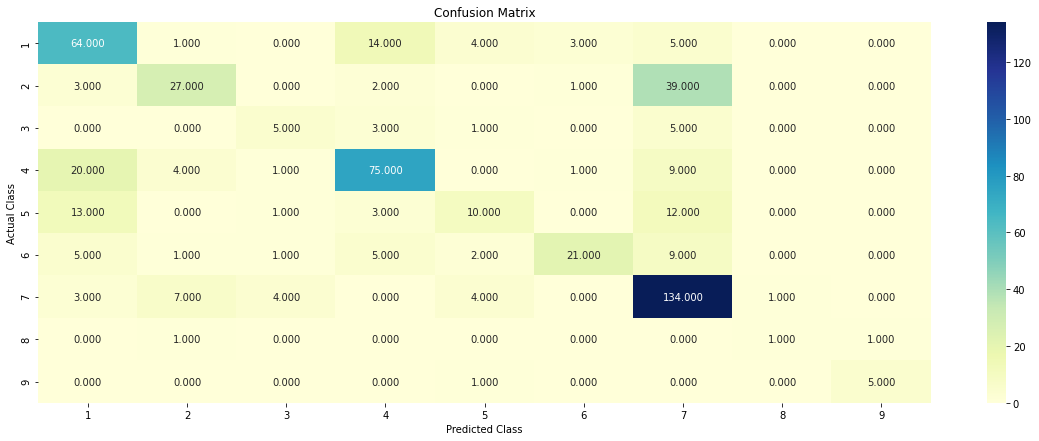

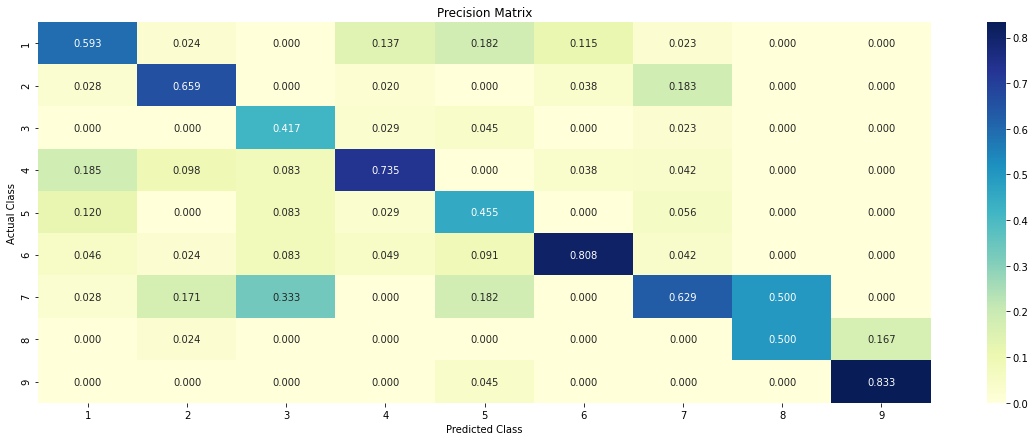

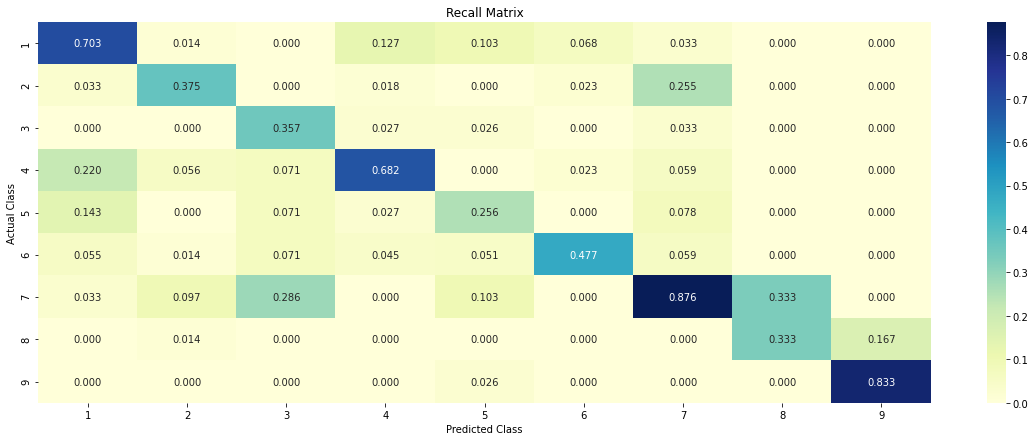

In [103]:
alpha_params = [10 ** x for x in range(-6, 3)]

lr_clf, lr_sig_clf = build_linear_model(
    X_train=X_train_gvt_onehot_code,
    X_cv=X_cv_gvt_onehot_code,
    X_test=X_test_gvt_onehot_code,
    y_train=y_train,
    y_cv=y_cv,
    y_test=y_test,
    loss_type='log',
    hparams=alpha_params,
    preserve_data_balancing=True,
    show_plot=True
)

In [104]:
check_model_nb_perf(
    dframe=test_df,
    X_test=X_test_gvt_onehot_code,
    y_test=y_test,
    query_point_index=1,
    n_feature_nums=100,
    clf=lr_clf,
    sig_clf=lr_sig_clf,
    text_col='TEXT',
    gene_col='Gene',
    var_col='Variation'
)

Predicted Class : 2
Predicted Class Probabilities : [[0.1316 0.416  0.0186 0.1026 0.0495 0.0352 0.2282 0.0066 0.0117]]
Actual Class : 2
--------------------------------------------------
Out of the top  100  features  0 are present in query point


In [105]:
check_model_nb_perf(
    dframe=test_df,
    X_test=X_test_gvt_onehot_code,
    y_test=y_test,
    query_point_index=23,
    n_feature_nums=100,
    clf=lr_clf,
    sig_clf=lr_sig_clf,
    text_col='TEXT',
    gene_col='Gene',
    var_col='Variation'
)

Predicted Class : 7
Predicted Class Probabilities : [[6.300e-03 5.100e-03 1.700e-03 6.500e-03 1.700e-03 6.000e-04 9.703e-01
  7.000e-03 8.000e-04]]
Actual Class : 7
--------------------------------------------------
76 Text feature [missense] present in test data point [True]
95 Text feature [constitutively] present in test data point [True]
Out of the top  100  features  2 are present in query point


**Logistic Regression** (without class balancing)

For alpha : 1e-06 → Log Loss : 1.2896975723209312
For alpha : 1e-05 → Log Loss : 1.2624801499646416
For alpha : 0.0001 → Log Loss : 1.1941854762425113
For alpha : 0.001 → Log Loss : 1.1577851228228382
For alpha : 0.01 → Log Loss : 1.275593597659451
For alpha : 0.1 → Log Loss : 1.4852371347342814
For alpha : 1 → Log Loss : 1.6356660309744815
For alpha : 10 → Log Loss : 1.6643240779169368
For alpha : 100 → Log Loss : 1.6674836411481344


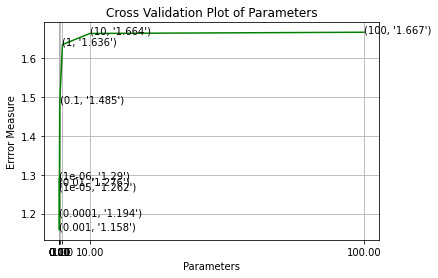

For the best param : 0.001; the training log loss is : 0.5204831664002799
For the best param : 0.001; the validation log loss is : 1.1577851228228382
For the best param : 0.001; the training log loss is : 1.1354223614697114
Number of missclassified points in Validation data : 0.3609022556390977
Number of missclassified points in Test data : 0.3473684210526316


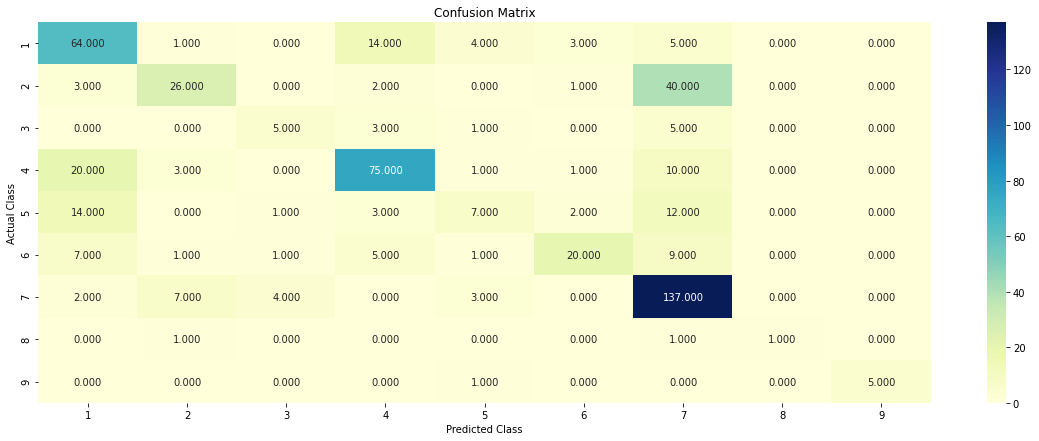

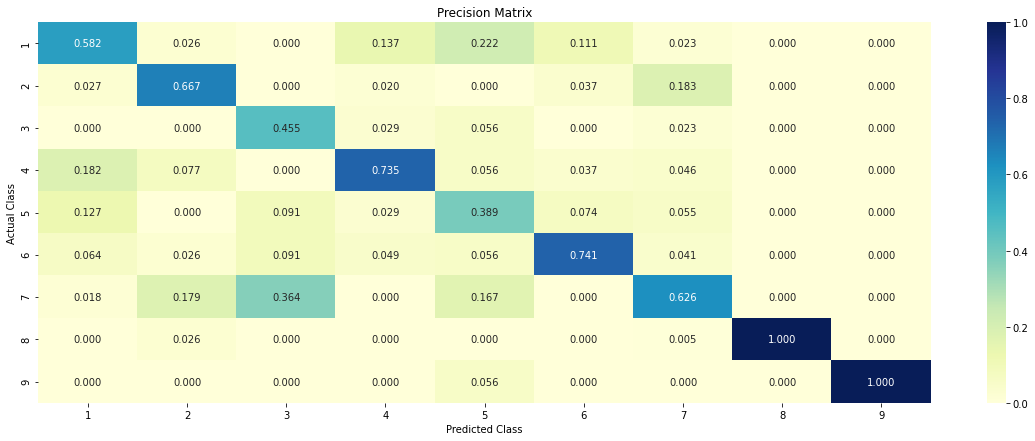

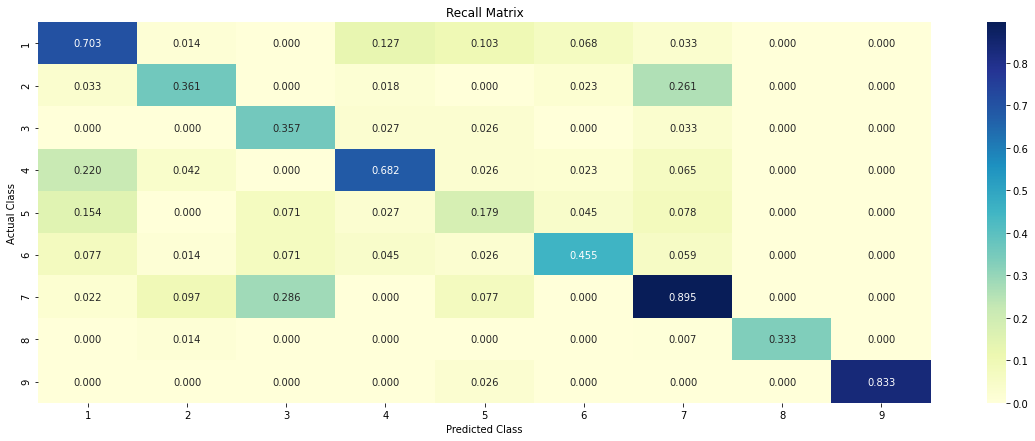

In [106]:
alpha_params = [10 ** x for x in range(-6, 3)]

lr_clf_wb, lr_sig_clf_wb = build_linear_model(
    X_train=X_train_gvt_onehot_code,
    X_cv=X_cv_gvt_onehot_code,
    X_test=X_test_gvt_onehot_code,
    y_train=y_train,
    y_cv=y_cv,
    y_test=y_test,
    loss_type='log',
    hparams=alpha_params,
    preserve_data_balancing=False,
    show_plot=True
)

Model Performance

In [107]:
check_model_nb_perf(
    dframe=test_df,
    X_test=X_test_gvt_onehot_code,
    y_test=y_test,
    query_point_index=1,
    n_feature_nums=100,
    clf=lr_clf_wb,
    sig_clf=lr_sig_clf_wb,
    text_col='TEXT',
    gene_col='Gene',
    var_col='Variation'
)

Predicted Class : 2
Predicted Class Probabilities : [[0.1273 0.4217 0.0222 0.0964 0.0524 0.0372 0.2228 0.0077 0.0124]]
Actual Class : 2
--------------------------------------------------
Out of the top  100  features  0 are present in query point


In [108]:
check_model_nb_perf(
    dframe=test_df,
    X_test=X_test_gvt_onehot_code,
    y_test=y_test,
    query_point_index=23,
    n_feature_nums=100,
    clf=lr_clf_wb,
    sig_clf=lr_sig_clf_wb,
    text_col='TEXT',
    gene_col='Gene',
    var_col='Variation'
)

Predicted Class : 7
Predicted Class Probabilities : [[6.500e-03 5.200e-03 7.000e-04 7.900e-03 1.500e-03 5.000e-04 9.697e-01
  6.100e-03 1.900e-03]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0 are present in query point


**Linear SVM** (with balancing)

For alpha : 1e-06 → Log Loss : 1.2973287425052435
For alpha : 1e-05 → Log Loss : 1.2918268064268457
For alpha : 0.0001 → Log Loss : 1.2304032368784206
For alpha : 0.001 → Log Loss : 1.1840229607619983
For alpha : 0.01 → Log Loss : 1.1879978871464807
For alpha : 0.1 → Log Loss : 1.434008630547072
For alpha : 1 → Log Loss : 1.7402636555155544
For alpha : 10 → Log Loss : 1.7473368483790883
For alpha : 100 → Log Loss : 1.7473497451562277


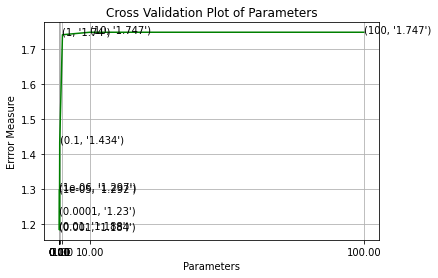

For the best param : 0.001; the training log loss is : 0.5244459054259921
For the best param : 0.001; the validation log loss is : 1.1840229607619983
For the best param : 0.001; the training log loss is : 1.1544223505350157
Number of missclassified points in Validation data : 0.3609022556390977
Number of missclassified points in Test data : 0.34887218045112783


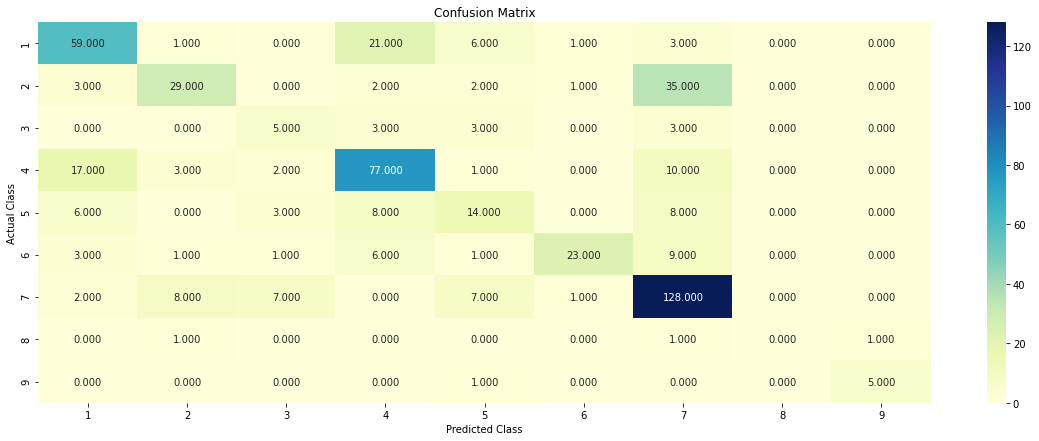

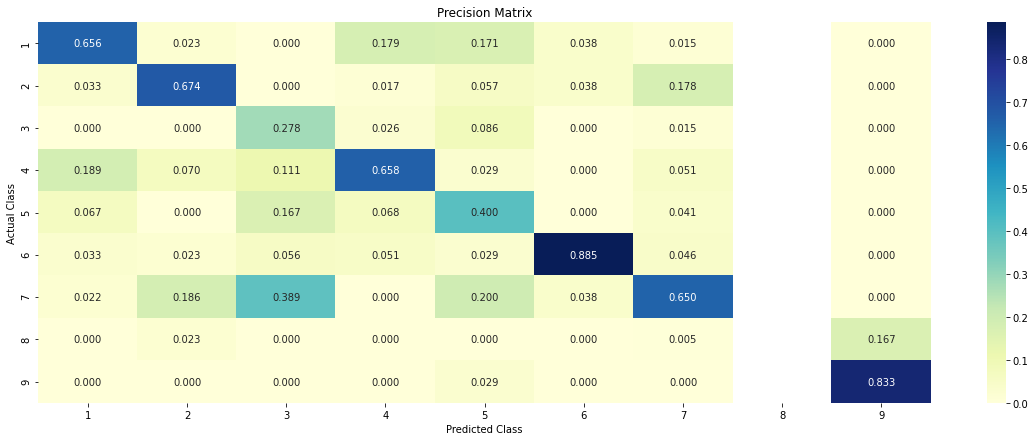

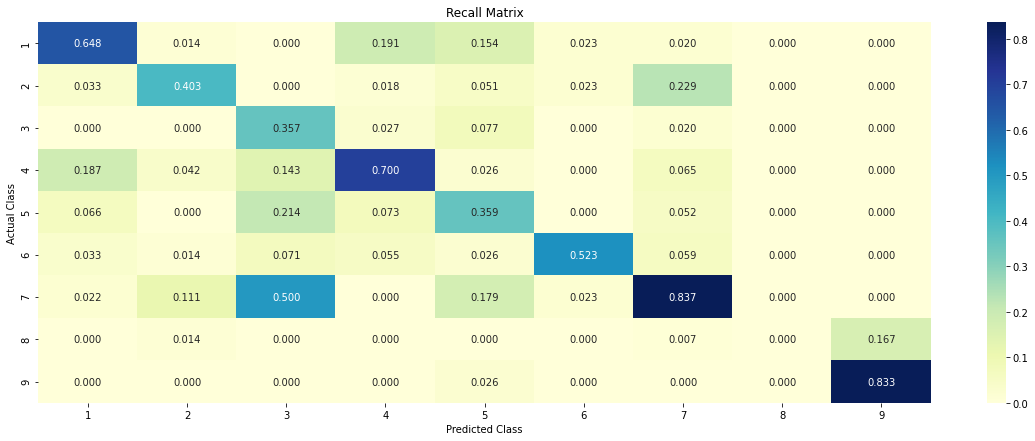

In [109]:
alpha_params = [10 ** x for x in range(-6, 3)]

svm_clf_wb, svm_sig_clf_wb = build_linear_model(
    X_train=X_train_gvt_onehot_code,
    X_cv=X_cv_gvt_onehot_code,
    X_test=X_test_gvt_onehot_code,
    y_train=y_train,
    y_cv=y_cv,
    y_test=y_test,
    loss_type='hinge',
    hparams=alpha_params,
    preserve_data_balancing=True,
    show_plot=True
)

Model Performance

In [110]:
check_model_nb_perf(
    dframe=test_df,
    X_test=X_test_gvt_onehot_code,
    y_test=y_test,
    query_point_index=1,
    n_feature_nums=100,
    clf=svm_clf_wb,
    sig_clf=svm_sig_clf_wb,
    text_col='TEXT',
    gene_col='Gene',
    var_col='Variation'
)

Predicted Class : 2
Predicted Class Probabilities : [[0.133  0.5061 0.0167 0.0994 0.0459 0.0217 0.163  0.0058 0.0084]]
Actual Class : 2
--------------------------------------------------
Out of the top  100  features  0 are present in query point


In [111]:
check_model_nb_perf(
    dframe=test_df,
    X_test=X_test_gvt_onehot_code,
    y_test=y_test,
    query_point_index=23,
    n_feature_nums=100,
    clf=svm_clf_wb,
    sig_clf=svm_sig_clf_wb,
    text_col='TEXT',
    gene_col='Gene',
    var_col='Variation'
)

Predicted Class : 7
Predicted Class Probabilities : [[0.0233 0.0218 0.0284 0.0148 0.0123 0.004  0.8834 0.0092 0.003 ]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0 are present in query point


**RandomForest Model**

For estimator : 100; depth : 5 → Log Loss : 1.2902696564620344
For estimator : 100; depth : 10 → Log Loss : 1.2057358065987909
For estimator : 200; depth : 5 → Log Loss : 1.2757267953644
For estimator : 200; depth : 10 → Log Loss : 1.1911304637298477
For estimator : 500; depth : 5 → Log Loss : 1.2688549204164203
For estimator : 500; depth : 10 → Log Loss : 1.1868634720222646
For estimator : 1000; depth : 5 → Log Loss : 1.272206107588945
For estimator : 1000; depth : 10 → Log Loss : 1.1869202588524044
For estimator : 2000; depth : 5 → Log Loss : 1.2745261594828765
For estimator : 2000; depth : 10 → Log Loss : 1.1882843972338335
For estimator : 500; depth : 10 → training Log Loss : 0.7061381120715982
For estimator : 500; depth : 10 → validation Log Loss : 1.1868634720222646
For estimator : 500; depth : 10 → testing Log Loss : 1.1788911807273503
Number of missclassified points in Validation data : 0.39285714285714285
Number of missclassified points in Test data : 0.39097744360902253


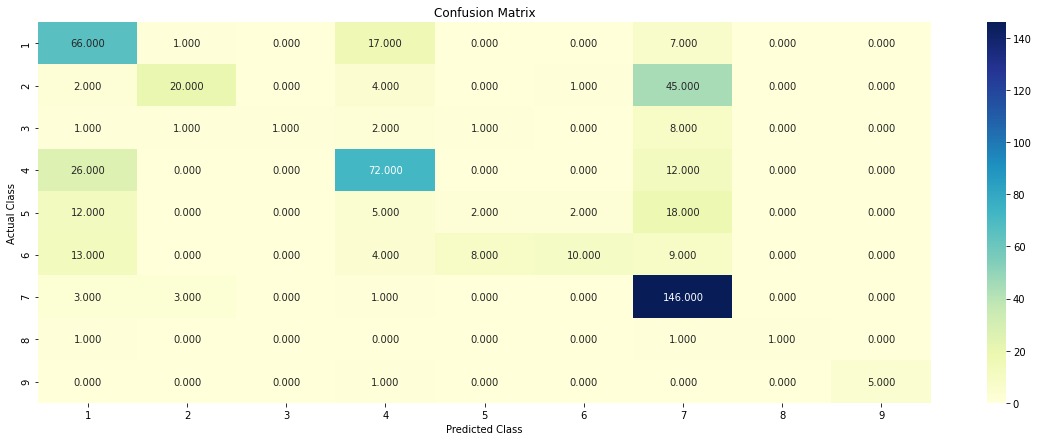

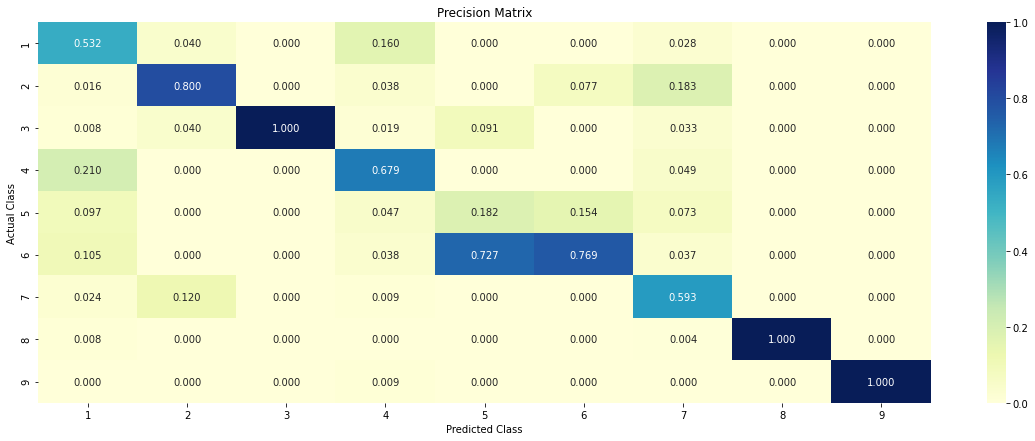

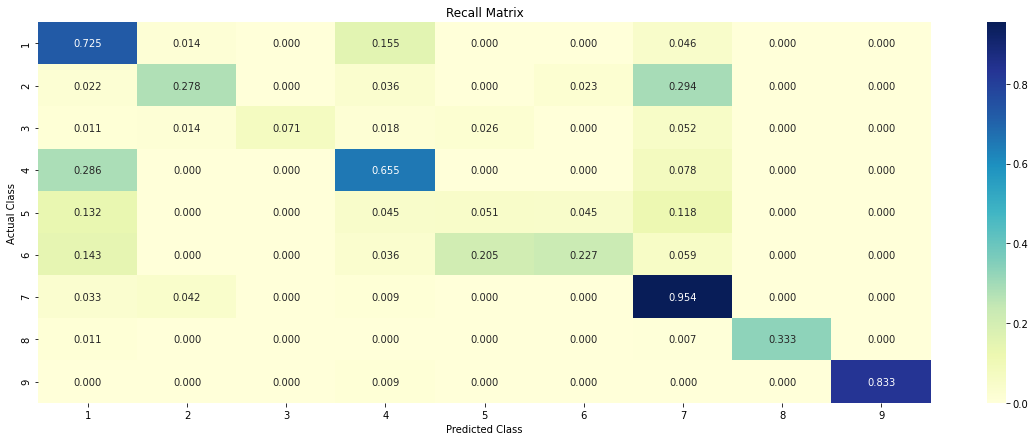

In [115]:
estimator_params = [100, 200, 500, 1000, 2000]
depth_params = [5, 10]

rf_clf, rf_sig_clf = build_tree_classifiers(
    X_train=X_train_gvt_onehot_code,
    X_cv=X_cv_gvt_onehot_code,
    X_test=X_test_gvt_onehot_code,
    y_train=y_train,
    y_cv=y_cv,
    y_test=y_test,
    estimator_params=estimator_params,
    depth_parms=depth_params,
    show_plot=True
)

Model Performace

In [123]:
# check_model_tree_perf(
#     dframe=test_df,
#     X_test=X_test_gvt_onehot_code,
#     y_test=y_test,
#     query_point_index=1,
#     n_feature_nums=100,
#     clf=rf_clf,
#     sig_clf=rf_sig_clf,
#     text_col='TEXT',
#     gene_col='Gene',
#     var_col='Variation'
# )

For estimator : 10; depth : 2 → Log Loss : 2.074120017494847
For estimator : 10; depth : 3 → Log Loss : 1.714233572296041
For estimator : 10; depth : 5 → Log Loss : 1.4428750540362676
For estimator : 10; depth : 10 → Log Loss : 1.7727343421011121
For estimator : 50; depth : 2 → Log Loss : 1.7270931890196741
For estimator : 50; depth : 3 → Log Loss : 1.485674298810481
For estimator : 50; depth : 5 → Log Loss : 1.488299978791787
For estimator : 50; depth : 10 → Log Loss : 1.6928548817275555
For estimator : 100; depth : 2 → Log Loss : 1.610953113145743
For estimator : 100; depth : 3 → Log Loss : 1.511465387203315
For estimator : 100; depth : 5 → Log Loss : 1.4309223022328637
For estimator : 100; depth : 10 → Log Loss : 1.6547571367627407
For estimator : 200; depth : 2 → Log Loss : 1.6621747139664627
For estimator : 200; depth : 3 → Log Loss : 1.5535595098368604
For estimator : 200; depth : 5 → Log Loss : 1.4824532928015368
For estimator : 200; depth : 10 → Log Loss : 1.7163458044254252
Fo

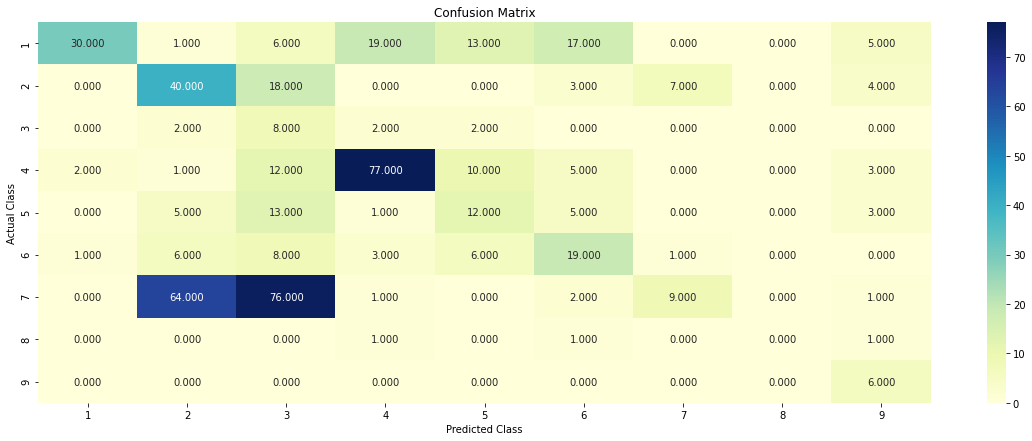

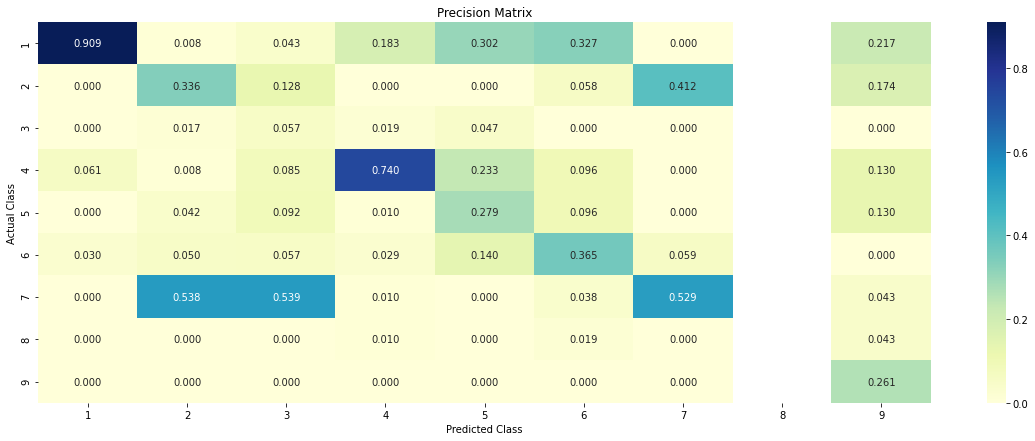

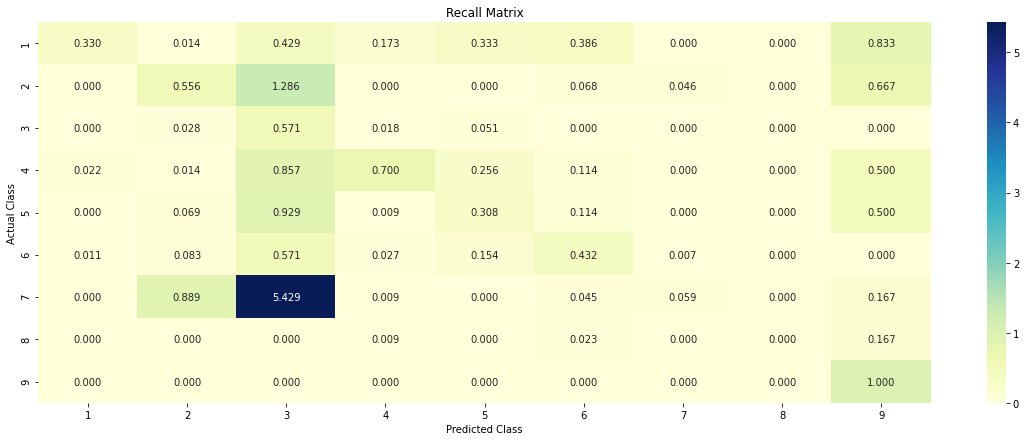

In [126]:
estimator_params = [10, 50, 100, 200, 500, 1000]
depth_params = [2, 3, 5, 10]

rf_clf_res, rf_sig_clf_res = build_tree_classifiers(
    X_train=X_train_gvt_response_code,
    X_cv=X_cv_gvt_response_code,
    X_test=X_test_gvt_response_code,
    y_train=y_train,
    y_cv=y_cv,
    y_test=y_test,
    estimator_params=estimator_params,
    depth_parms=depth_params,
    show_plot=True
)

### Stacking Classifiers

In [129]:
# clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
# clf1.fit(X_train_gvt_onehot_code, y_train)
# sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

# clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
# clf2.fit(X_train_gvt_onehot_code, y_train)
# sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

# clf3 = MultinomialNB(alpha=0.001)
# clf3.fit(X_train_gvt_onehot_code, y_train)
# sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

# sig_clf1.fit(X_train_gvt_onehot_code, y_train)
# print("Logistic Regression → Log Loss : %0.2f" % (log_loss(y_cv, sig_clf1.predict_proba(X_cv_gvt_onehot_code))))
# sig_clf2.fit(X_train_gvt_onehot_code, y_train)
# print("Support vector machines → Log Loss : %0.2f" % (log_loss(y_cv, sig_clf2.predict_proba(X_cv_gvt_onehot_code))))
# sig_clf3.fit(X_train_gvt_onehot_code, y_train)
# print("Naive Bayes → Log Loss : %0.2f" % (log_loss(y_cv, sig_clf3.predict_proba(X_cv_gvt_onehot_code))))
# print("-"*50)

# alpaha_params = [0.0001, 0.001, 0.01, 0.1,1, 10]
# best_alpha = 999
# for i in alpaha_params:
#     lr = LogisticRegression(C=i)
#     sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
#     sclf.fit(train_x_onehotCoding, train_y)
#     print("Stacking Classifer for the value of alpha : %f Log Loss : %0.3f" % (i, log_loss(y_cv, sclf.predict_proba(X_cv_gvt_onehot_code))))
#     log_error = log_loss(y_cv, sclf.predict_proba(X_cv_gvt_onehot_code))
#     if (best_alpha > log_error):
#         best_alpha = log_error